# Experiment 03: Transformer for Temporal Anomaly Detection

## Experiment Goal
Evaluate the effectiveness of **Transformer Encoders** (Self-Attention mechanism) for modeling the temporal dynamics of latent plasma states, compared to the LSTM baseline.

## Hypothesis
Transformers can capture long-range dependencies more effectively than RNNs via self-attention and allow for parallelized training. This may lead to more accurate forecasting of complex, non-linear plasma dynamics.

## Methodology
1.  **Model Architecture:** Replace the LSTM block with a Transformer Encoder block (Multi-Head Attention + Feed Forward Network).
2.  **Training:** Train on the same latent features extracted by the VAE.
3.  **Evaluation:** Compare prediction error (MSE) and computational efficiency.


In [1]:
# --- Importing necessary libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import ruptures as rpt

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os

# Get the directory of the current notebook/script
current_dir = os.path.dirname(os.path.abspath('autoencoder test.ipynb'))
# Or use this for Jupyter notebooks:
try:
    notebook_dir = os.getcwd()
except:
    notebook_dir = os.path.dirname(os.path.abspath(__file__))

# Construct the path to the data file relative to the script location
# Data is located in the parent directory's 'data copy' folder
file_path = os.path.join(notebook_dir, '..', 'data copy', 'Comp_1.pkl')

# Load the pickle file (wavelengths are stored in the index)
oes_data = pd.read_pickle(file_path)

# Extract the physical wavelength axis (in nm) from the index
wavelength_values = oes_data.index.astype(float)
wavelengths = pd.Series(wavelength_values, name='wavelength_nm').reset_index(drop=True)

# The remaining columns represent intensity values at different time steps
intensities = oes_data.copy()

# Handle missing values by filling with 0
intensities = intensities.fillna(0)

# Normalize the intensity values between 0 and 1
scaler = MinMaxScaler()
normalized_intensities = scaler.fit_transform(intensities)

# Convert the normalized intensities back to a DataFrame for easier processing (preserve wavelength index)
normalized_data = pd.DataFrame(
    normalized_intensities,
    columns=intensities.columns,
    index=wavelength_values
)

# Print the first few rows of the normalized data
normalized_data.head()

,0,1,2,3,4,5,6,7,8,9,...,2240,2241,2242,2243,2244,2245,2246,2247,2248,2249
wavelength (nm),,,,,,,,,,,,,,,,,,,,,
195.000000,0.029032,0.017983,0.023687,0.020947,0.023803,0.025028,0.024247,0.019450,0.025113,0.019336,...,0.022005,0.023086,0.017464,0.021877,0.028129,0.033678,0.024031,0.016128,0.022533,0.022139
195.199997,0.024462,0.017914,0.024027,0.022549,0.019987,0.023850,0.019565,0.018349,0.021765,0.021035,...,0.018923,0.021803,0.015264,0.024300,0.027649,0.032418,0.021031,0.013304,0.020104,0.020407
195.399994,0.022736,0.019641,0.024959,0.021382,0.019374,0.022753,0.017979,0.018877,0.020441,0.021097,...,0.019533,0.021080,0.016917,0.025592,0.025304,0.029186,0.019793,0.016145,0.021730,0.019580
195.600006,0.022147,0.022088,0.026128,0.019108,0.020042,0.021690,0.017631,0.020056,0.019927,0.020504,...,0.021567,0.020572,0.020055,0.026447,0.022239,0.025195,0.019235,0.021170,0.024922,0.019103
195.800003,0.021594,0.024429,0.027279,0.016904,0.020713,0.020742,0.017331,0.021205,0.019453,0.019938,...,0.023614,0.020217,0.023101,0.027294,0.019252,0.021441,0.018778,0.025931,0.027961,0.018687


In [3]:
## Data Transformation 


transposed_data = normalized_data.T
transposed_data_np = transposed_data.to_numpy()

In [4]:
# --- VAE Model Definition ---

# Sampling function for VAE
def sampling(z_mean, z_log_var):
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build VAE Encoder
def build_encoder(input_dim, latent_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)  # Latent mean
    z_log_var = layers.Dense(latent_dim)(x)  # Latent log variance
    return models.Model(inputs, [z_mean, z_log_var], name='encoder')

# Build VAE Decoder
def build_decoder(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(latent_inputs)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    return models.Model(latent_inputs, outputs, name='decoder')

# Define VAE Model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = sampling(z_mean, z_log_var)
        return self.decoder(z)

## Step 2: Hyperparameter Optimization with Keras Tuner
The **latent dimension is a key hyperparameter** of the VAE. Instead of manual trial-and-error (which gives inconsistent results due to random initialization), we use **Keras Tuner** to systematically search the hyperparameter space:
- **Latent Dimension:** 2–15 (controls model capacity and interpretability)
- **Learning Rate:** 1e-4 to 1e-2 (affects convergence speed)

Keras Tuner runs multiple training trials with different configurations and selects the combination that minimizes reconstruction loss on a validation set. This ensures reproducible, data-driven hyperparameter selection.

In [5]:
# --- Automated Hyperparameter Search for the VAE ---
try:
    import keras_tuner as kt
except ImportError:
    import sys
    !{sys.executable} -m pip install -q keras-tuner
    import keras_tuner as kt

import shutil
import os

# Define input dimension based on the data
input_dim = transposed_data_np.shape[1]

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Clean up any existing tuner directory completely before starting
tuner_dir = 'kt_logs'
if os.path.exists(tuner_dir):
    try:
        shutil.rmtree(tuner_dir, ignore_errors=True)
        print(f"✓ Cleaned up previous tuner directory: {tuner_dir}")
    except Exception as e:
        print(f"Warning during cleanup: {e}")

# Ensure directory is gone
import time
time.sleep(0.2)  # Brief pause to ensure filesystem sync

# Builder that KerasTuner will call for each trial
def vae_model_builder(hp):
    latent_dim_hp = hp.Int('latent_dim', min_value=2, max_value=15, step=1)
    lr_hp = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    encoder_hp = build_encoder(input_dim, latent_dim_hp)
    decoder_hp = build_decoder(latent_dim_hp, input_dim)
    vae_hp = VAE(encoder_hp, decoder_hp)
    vae_hp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_hp), loss='mse')
    return vae_hp

# Use BayesianOptimization for more efficient search than RandomSearch
# Note: overwrite=False since we manually cleaned the directory above
tuner = kt.BayesianOptimization(
    vae_model_builder,
    objective='val_loss',  # Optimize validation loss to avoid overfitting
    max_trials=15,
    overwrite=False,  # We already manually cleaned, so don't let TF try to delete
    directory='kt_logs',
    project_name='vae_hp_search',
    seed=42
)

print("Starting Keras Tuner hyperparameter search...")
print(f"Search space: latent_dim=[2-15], learning_rate=[1e-4, 1e-2]")

tuner.search(
    transposed_data_np,
    transposed_data_np,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Get best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
best_latent_dim = best_hp.get('latent_dim')
best_learning_rate = best_hp.get('learning_rate')

print("\n" + "="*60)
print(f"✓ KerasTuner selected: latent_dim = {best_latent_dim}")
print(f"✓ KerasTuner selected: learning_rate = {best_learning_rate:.5f}")
print("="*60)

Trial 15 Complete [00h 00m 49s]
val_loss: 0.024907909333705902

Best val_loss So Far: 0.02462749555706978
Total elapsed time: 00h 12m 01s

✓ KerasTuner selected: latent_dim = 11
✓ KerasTuner selected: learning_rate = 0.00175


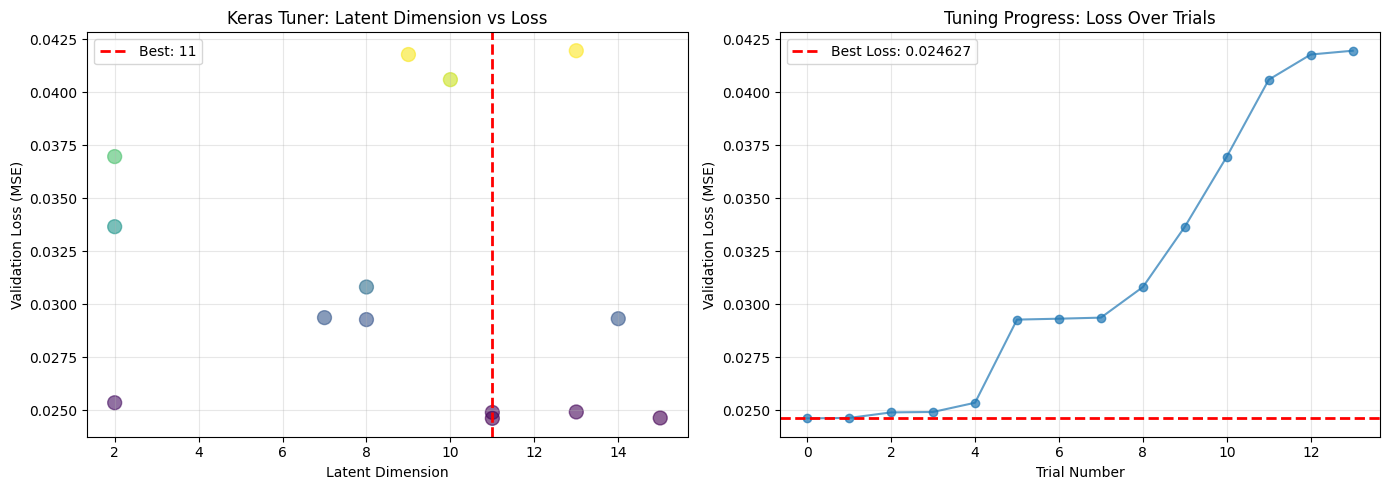


Summary:
  Total trials: 15
  Best latent_dim: 11
  Best val_loss: 0.024627
  Interpretation: The optimal latent dimension balances reconstruction accuracy and model simplicity.


In [6]:
# --- Visualize Hyperparameter Tuning Results ---

# Extract trial history
trials = tuner.oracle.get_best_trials(num_trials=15)

trial_latent_dims = []
trial_losses = []

for trial in trials:
    trial_latent_dims.append(trial.hyperparameters.values['latent_dim'])
    trial_losses.append(trial.score)  # val_loss

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Latent Dimension vs Validation Loss
axes[0].scatter(trial_latent_dims, trial_losses, alpha=0.6, s=100, c=trial_losses, cmap='viridis')
axes[0].axvline(x=best_latent_dim, color='r', linestyle='--', linewidth=2, label=f'Best: {best_latent_dim}')
axes[0].set_xlabel('Latent Dimension')
axes[0].set_ylabel('Validation Loss (MSE)')
axes[0].set_title('Keras Tuner: Latent Dimension vs Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Trial progression
axes[1].plot(range(len(trial_losses)), trial_losses, marker='o', linestyle='-', alpha=0.7)
axes[1].axhline(y=min(trial_losses), color='r', linestyle='--', linewidth=2, label=f'Best Loss: {min(trial_losses):.6f}')
axes[1].set_xlabel('Trial Number')
axes[1].set_ylabel('Validation Loss (MSE)')
axes[1].set_title('Tuning Progress: Loss Over Trials')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSummary:")
print(f"  Total trials: {len(trials)}")
print(f"  Best latent_dim: {best_latent_dim}")
print(f"  Best val_loss: {min(trial_losses):.6f}")
print(f"  Interpretation: The optimal latent dimension balances reconstruction accuracy and model simplicity.")

In [7]:
# --- Build and Train VAE ---

# Force latent dimension to 6 for explainability
latent_dim = 6 

# Use learning rate from tuner if available, otherwise default
learning_rate = best_learning_rate if 'best_learning_rate' in globals() else 1e-3

print(f"Training final VAE with latent_dim = {latent_dim} | learning_rate = {learning_rate:.5f}")
if 'best_latent_dim' in globals():
    print(f"(Reference: Keras Tuner suggested latent_dim = {best_latent_dim})")

# Set dimensions for VAE
input_dim = transposed_data_np.shape[1]  # number of wavelength samples

# Build encoder and decoder
encoder = build_encoder(input_dim, latent_dim)
decoder = build_decoder(latent_dim, input_dim)

# Create VAE model
vae = VAE(encoder, decoder)

# Compile the VAE
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

Training final VAE with latent_dim = 6 | learning_rate = 0.00175
(Reference: Keras Tuner suggested latent_dim = 11)


### Latent Dimension Selection Result
The sweep above evaluated multiple latent sizes and identified the dimension that minimizes reconstruction loss while remaining compact. We now reuse that optimal size for the final VAE so the latent space remains physically interpretable yet accurate.

In [8]:
# Train the VAE
vae.fit(transposed_data_np, transposed_data_np, epochs=70, batch_size=32)

# --- Extract Latent Features from VAE Encoder ---

# Use the trained VAE encoder to get the latent space representation
latent_features = vae.encoder(transposed_data_np)[0].numpy()  # The [0] selects the z_mean

# The shape of `latent_features` is (num_time_steps, latent_dim)
print(f"Shape of latent features: {latent_features.shape}")

Epoch 1/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0477
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0477
Epoch 2/70
Epoch 2/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0051
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0051
Epoch 3/70
Epoch 3/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011
Epoch 4/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011
Epoch 4/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 5/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 5/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0068
Epoch 6/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0068
Epoch 6/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0177
Epoch 7/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0177
Epoch 7/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0312
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0312
Epoch 8/70
Epoch 8/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0304
Epoch 9/70

## Step 4: Explainable AI (XAI) - Interpreting the Latent Space
Now that the VAE is trained, we employ multiple visualization techniques to understand the physical meaning of each latent dimension:

1. **Latent Traversal with Spectral Analysis**: Varies each dimension while highlighting which wavelength regions are affected
2. **Latent Feature Correlation Matrix**: Shows how dimensions relate to each other
3. **Temporal Evolution Heatmap**: Visualizes how latent features change over the process timeline
4. **Reconstruction Contribution Analysis**: Quantifies which dimensions contribute most to different spectral regions

Visualizing Enhanced Latent Space Analysis (Latent Dim = 6)...


/var/folders/xh/trthgtsx4b5gv8pt9bbts6qr0000gn/T/ipykernel_21210/2765541700.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


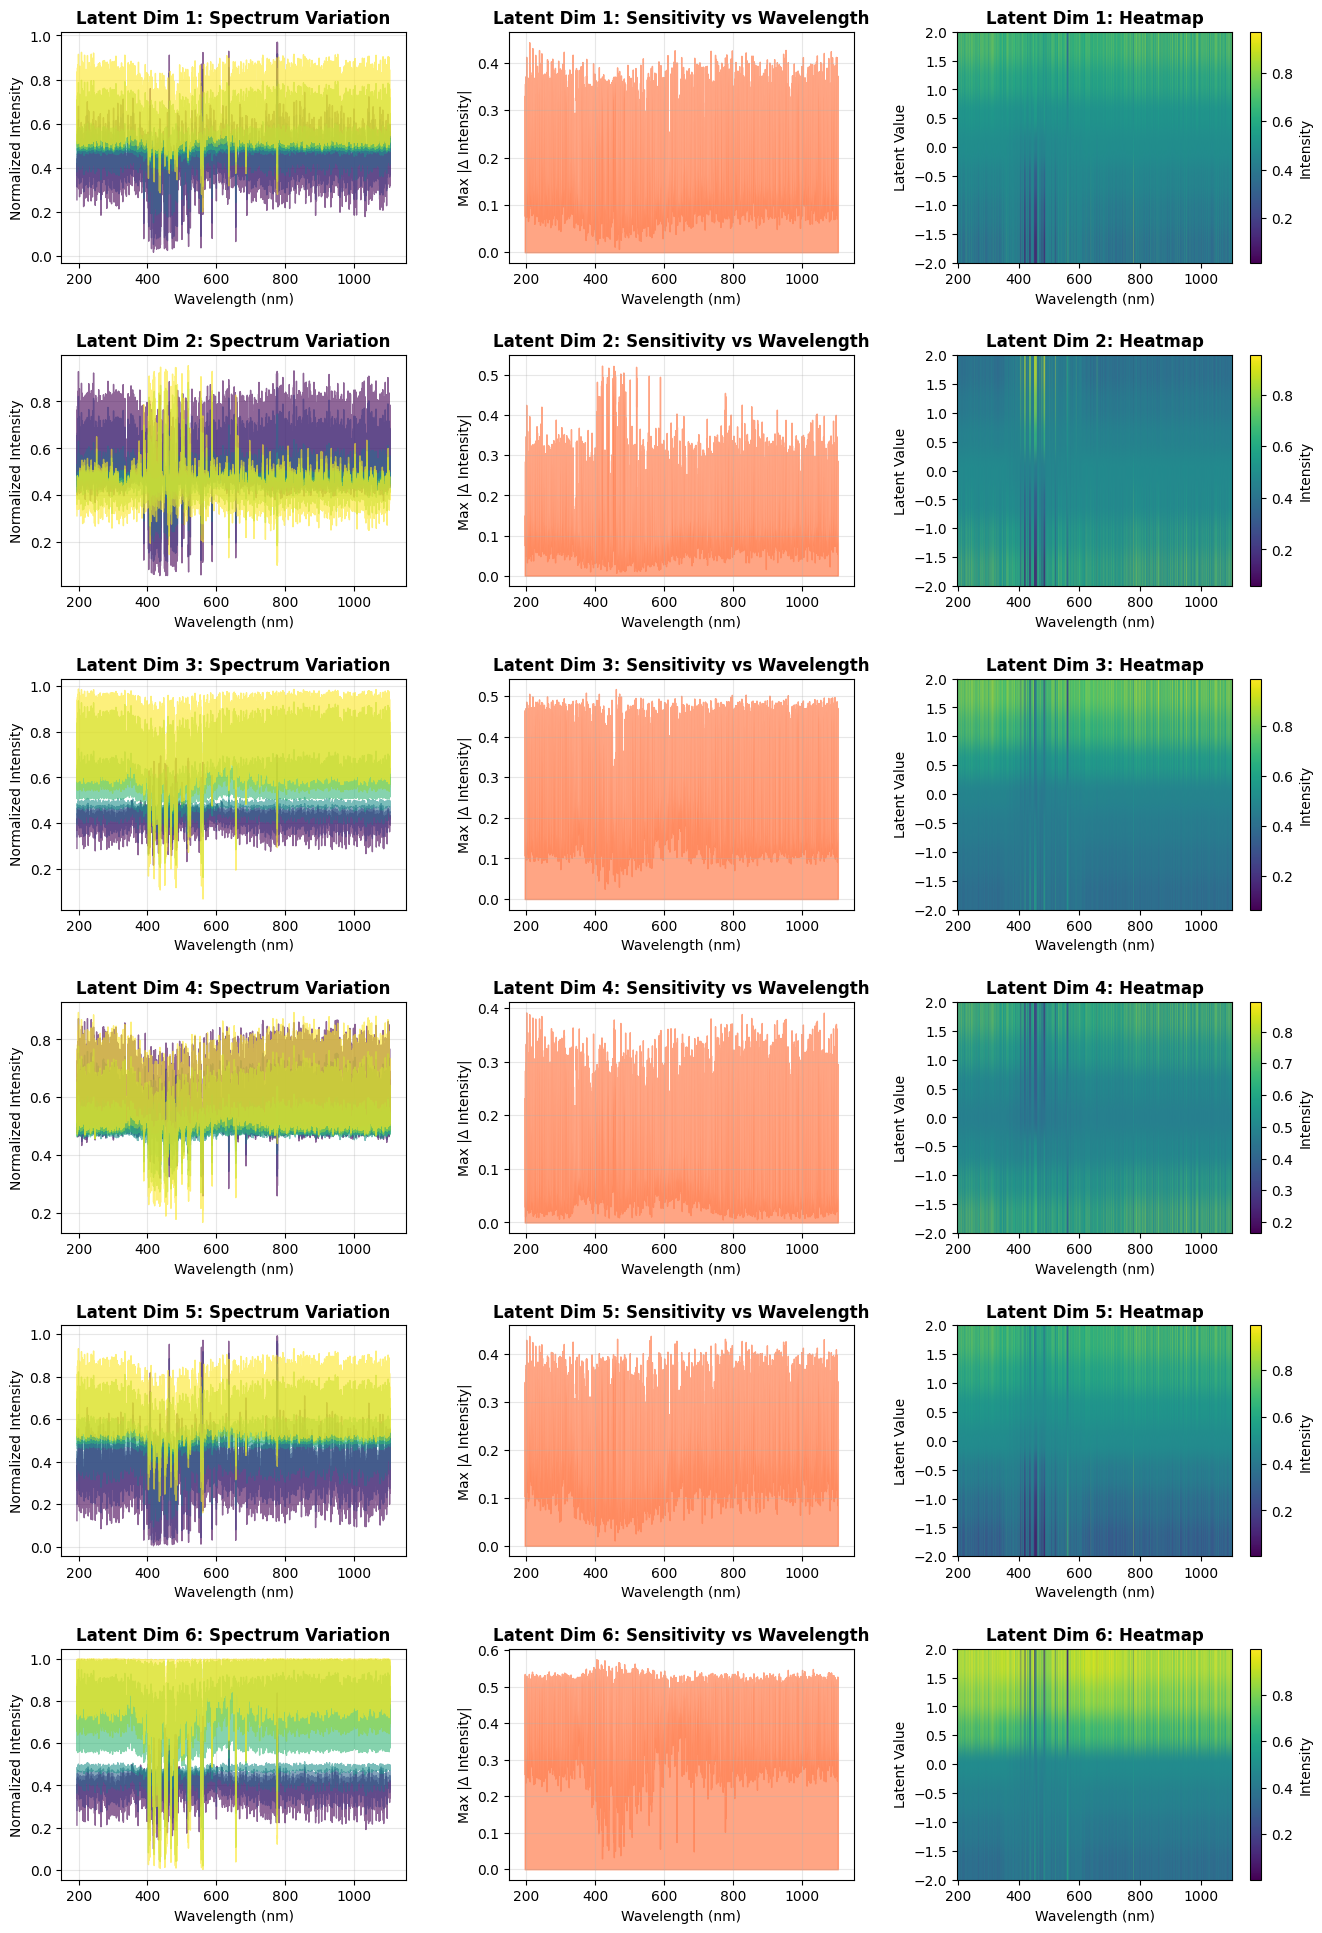

Latent dim 1 top wavelengths:
  λ = 208.20 nm, sensitivity = 0.443583
  λ = 217.20 nm, sensitivity = 0.431226
  λ = 952.80 nm, sensitivity = 0.427344
-
Latent dim 2 top wavelengths:
  λ = 419.60 nm, sensitivity = 0.523701
  λ = 452.80 nm, sensitivity = 0.523144
  λ = 518.60 nm, sensitivity = 0.520766
-
Latent dim 3 top wavelengths:
  λ = 459.80 nm, sensitivity = 0.517385
  λ = 372.80 nm, sensitivity = 0.508521
  λ = 469.40 nm, sensitivity = 0.506290
-
Latent dim 4 top wavelengths:
  λ = 199.40 nm, sensitivity = 0.392104
  λ = 1064.00 nm, sensitivity = 0.391673
  λ = 825.60 nm, sensitivity = 0.389157
-
Latent dim 5 top wavelengths:
  λ = 561.20 nm, sensitivity = 0.438484
  λ = 208.20 nm, sensitivity = 0.438287
  λ = 463.40 nm, sensitivity = 0.432394
-
Latent dim 6 top wavelengths:
  λ = 403.20 nm, sensitivity = 0.575507
  λ = 406.40 nm, sensitivity = 0.574178
  λ = 426.60 nm, sensitivity = 0.572648
-


In [9]:
# --- XAI Visualization 1: Enhanced Latent Space Traversal with Spectral Analysis ---

import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec


def plot_enhanced_latent_traversal(vae, latent_dim, input_dim, wavelengths, n_steps=7, z_range=2.0):
    """Enhanced latent traversal with wavelength mapping and sensitivity analysis.

    Returns
    -------
    latent_sensitivity : np.ndarray, shape (latent_dim, input_dim)
        For each latent dimension, the maximum absolute change in intensity at
        each wavelength when that dimension is varied in [-z_range, z_range].
    """
    # Convert wavelengths to numpy array for consistent indexing
    wavelengths_np = wavelengths.to_numpy() if hasattr(wavelengths, 'to_numpy') else np.array(wavelengths)
    
    # Use a small random baseline in latent space to avoid flat reconstructions
    # (helps if decoder around 0 is very flat)
    z_base = np.zeros((1, latent_dim))

    # Baseline reconstruction
    baseline_spectrum = vae.decoder(z_base).numpy()[0]

    fig = plt.figure(figsize=(16, 4 * latent_dim))
    gs = GridSpec(latent_dim, 3, figure=fig, wspace=0.3, hspace=0.4)

    grid_x = np.linspace(-z_range, z_range, n_steps)
    colors = cm.viridis(np.linspace(0, 1, n_steps))

    latent_sensitivity = np.zeros((latent_dim, input_dim))

    for i in range(latent_dim):
        # Left plot: Full spectrum traversal
        ax1 = fig.add_subplot(gs[i, 0])

        decoded_spectra = []
        for idx_z, z_val in enumerate(grid_x):
            z_sample = z_base.copy()
            z_sample[0, i] = z_val
            x_decoded = vae.decoder(z_sample).numpy()[0]
            decoded_spectra.append(x_decoded)
            ax1.plot(wavelengths_np, x_decoded,
                     color=colors[idx_z],
                     alpha=0.6, linewidth=1.0)

        ax1.set_title(f'Latent Dim {i+1}: Spectrum Variation', fontweight='bold')
        ax1.set_xlabel('Wavelength (nm)')
        ax1.set_ylabel('Normalized Intensity')
        ax1.grid(alpha=0.3)

        # Middle plot: Difference from baseline (sensitivity) over wavelength
        ax2 = fig.add_subplot(gs[i, 1])

        max_diff = np.zeros(input_dim)
        for spectrum in decoded_spectra:
            diff = np.abs(spectrum - baseline_spectrum)
            max_diff = np.maximum(max_diff, diff)

        latent_sensitivity[i] = max_diff  # store for later analysis

        ax2.fill_between(wavelengths_np, 0, max_diff, alpha=0.7, color='coral')
        ax2.set_title(f'Latent Dim {i+1}: Sensitivity vs Wavelength', fontweight='bold')
        ax2.set_xlabel('Wavelength (nm)')
        ax2.set_ylabel('Max |Δ Intensity|')
        ax2.grid(alpha=0.3)

        # Right plot: Heatmap of traversal (wavelength vs latent value)
        ax3 = fig.add_subplot(gs[i, 2])

        traversal_matrix = np.array(decoded_spectra)
        im = ax3.imshow(
            traversal_matrix,
            aspect='auto',
            cmap='viridis',
            extent=[float(wavelengths_np.min()), float(wavelengths_np.max()), -z_range, z_range],
            origin='lower'
        )
        ax3.set_title(f'Latent Dim {i+1}: Heatmap', fontweight='bold')
        ax3.set_xlabel('Wavelength (nm)')
        ax3.set_ylabel('Latent Value')
        plt.colorbar(im, ax=ax3, label='Intensity')

    plt.tight_layout()
    plt.show()

    return latent_sensitivity


print(f"Visualizing Enhanced Latent Space Analysis (Latent Dim = {latent_dim})...")
latent_sensitivity = plot_enhanced_latent_traversal(vae, latent_dim, input_dim, wavelengths)

# Example: print top-3 wavelengths per latent dimension by sensitivity
top_k = 3
for i in range(latent_dim):
    idx = np.argsort(latent_sensitivity[i])[::-1][:top_k]
    print(f"Latent dim {i+1} top wavelengths:")
    for j in idx:
        wl_value = float(wavelengths.iloc[j]) if hasattr(wavelengths, 'iloc') else float(wavelengths[j])
        print(f"  λ = {wl_value:.2f} nm, sensitivity = {latent_sensitivity[i, j]:.6f}")
    print("-")

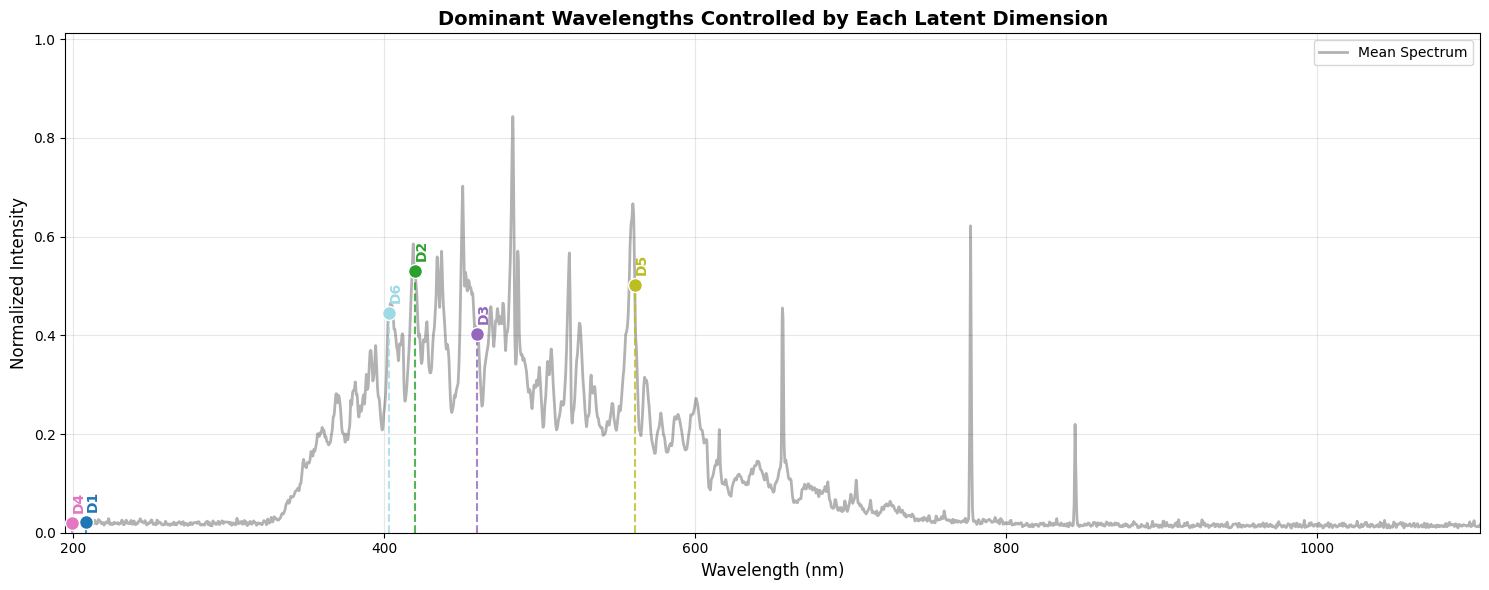

Interpretation:
  - The black line is the average plasma spectrum across all time steps.
  - Each colored marker (D1, D2, etc.) shows the wavelength where that latent dimension has the STRONGEST effect.
  - This directly maps the 'black box' latent variables to specific physical emission lines (e.g., Ar, O, F, etc.).
  - Wavelength range: 195.00 - 1104.80 nm


In [10]:
# --- XAI Visualization 1b: Latent Dimension Peak Mapping ---
# This plot overlays the "dominant" wavelength for each latent dimension onto the mean spectrum.
# It helps identify exactly which spectral peak each dimension is tracking.

# Calculate mean spectrum for context
mean_spectrum = np.mean(transposed_data_np, axis=0)

# Convert wavelengths to numpy array for consistent indexing
wavelengths_np = wavelengths.to_numpy() if hasattr(wavelengths, 'to_numpy') else np.array(wavelengths)

plt.figure(figsize=(15, 6))
plt.plot(wavelengths_np, mean_spectrum, 'k-', alpha=0.3, label='Mean Spectrum', linewidth=2)

# Use a distinct color for each dimension
colors = plt.cm.tab20(np.linspace(0, 1, latent_dim))

# Ensure latent_sensitivity exists (from previous cell)
if 'latent_sensitivity' not in globals():
    print("Please run the 'Enhanced Latent Space Traversal' cell first to generate latent_sensitivity.")
else:
    # For each dimension, find the max sensitivity wavelength and plot it
    for i in range(latent_dim):
        sens = latent_sensitivity[i]
        
        # Find index of max sensitivity
        max_idx = np.argmax(sens)
        max_wave = float(wavelengths_np[max_idx])
        
        # Find the intensity of the mean spectrum at this wavelength (for plotting height)
        max_val = mean_spectrum[max_idx]
        
        # Plot vertical line and label
        plt.vlines(max_wave, 0, max_val, colors=colors[i], linestyles='--', alpha=0.8, linewidth=1.5)
        plt.scatter(max_wave, max_val, color=colors[i], s=100, zorder=5, edgecolors='white', linewidths=1)
        plt.text(max_wave, max_val + 0.02, f'D{i+1}', color=colors[i], 
                 rotation=90, verticalalignment='bottom', fontweight='bold', fontsize=10)

    plt.title('Dominant Wavelengths Controlled by Each Latent Dimension', fontweight='bold', fontsize=14)
    plt.xlabel('Wavelength (nm)', fontsize=12)
    plt.ylabel('Normalized Intensity', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    plt.ylim(0, np.max(mean_spectrum) * 1.2)  # Add some headroom for labels
    plt.xlim(wavelengths_np.min(), wavelengths_np.max())  # Set x-axis to wavelength range

    plt.tight_layout()
    plt.show()

    print("Interpretation:")
    print("  - The black line is the average plasma spectrum across all time steps.")
    print("  - Each colored marker (D1, D2, etc.) shows the wavelength where that latent dimension has the STRONGEST effect.")
    print("  - This directly maps the 'black box' latent variables to specific physical emission lines (e.g., Ar, O, F, etc.).")
    print(f"  - Wavelength range: {wavelengths_np.min():.2f} - {wavelengths_np.max():.2f} nm")

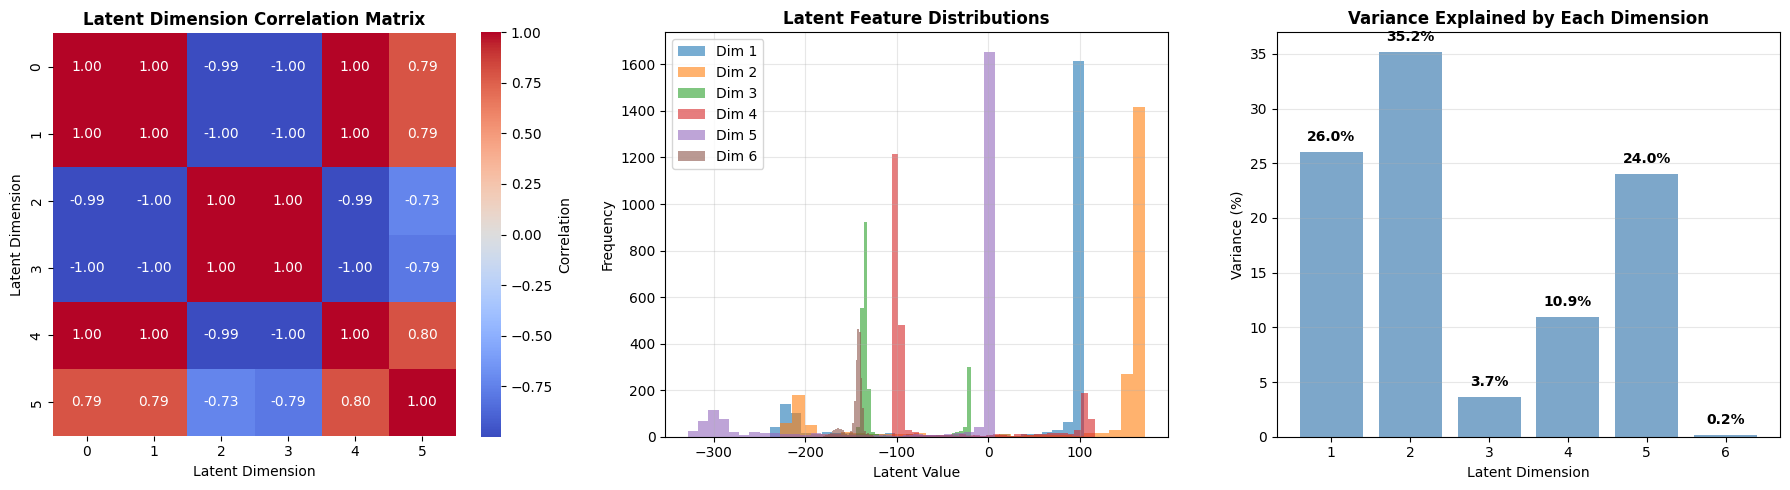

Interpretation:
  - Correlation matrix shows if dimensions are independent or redundant
  - Distribution plots reveal if dimensions capture distinct patterns
  - Variance plot indicates which dimensions carry the most information


In [11]:
# --- XAI Visualization 2: Latent Feature Correlation and Statistics ---

import seaborn as sns

# Safety: replace any NaNs/Infs in latent_features before stats
latent_features_clean = np.nan_to_num(latent_features, nan=0.0, posinf=0.0, neginf=0.0)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Correlation matrix between latent dimensions
corr_matrix = np.corrcoef(latent_features_clean.T)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Latent Dimension Correlation Matrix', fontweight='bold')
axes[0].set_xlabel('Latent Dimension')
axes[0].set_ylabel('Latent Dimension')

# Plot 2: Distribution of each latent dimension
for i in range(latent_dim):
    dim_vals = latent_features_clean[:, i]
    # Skip all-zero or constant dims to avoid empty / degenerate hist ranges
    if np.all(dim_vals == dim_vals[0]):
        continue
    axes[1].hist(dim_vals, bins=30, alpha=0.6, label=f'Dim {i+1}')
axes[1].set_title('Latent Feature Distributions', fontweight='bold')
axes[1].set_xlabel('Latent Value')
axes[1].set_ylabel('Frequency')
if axes[1].has_data():
    axes[1].legend()
axes[1].grid(alpha=0.3)

# Plot 3: Variance explained by each dimension
variances = np.var(latent_features_clean, axis=0)
if np.allclose(variances.sum(), 0):
    variance_pct = np.zeros_like(variances)
else:
    variance_pct = 100 * variances / variances.sum()
axes[2].bar(range(1, latent_dim+1), variance_pct, color='steelblue', alpha=0.7)
axes[2].set_title('Variance Explained by Each Dimension', fontweight='bold')
axes[2].set_xlabel('Latent Dimension')
axes[2].set_ylabel('Variance (%)')
axes[2].grid(alpha=0.3, axis='y')

# Add variance values on bars
for i, v in enumerate(variance_pct):
    axes[2].text(i+1, v + 1 if v >= 0 else 0, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("Interpretation:")
print("  - Correlation matrix shows if dimensions are independent or redundant")
print("  - Distribution plots reveal if dimensions capture distinct patterns")
print("  - Variance plot indicates which dimensions carry the most information")

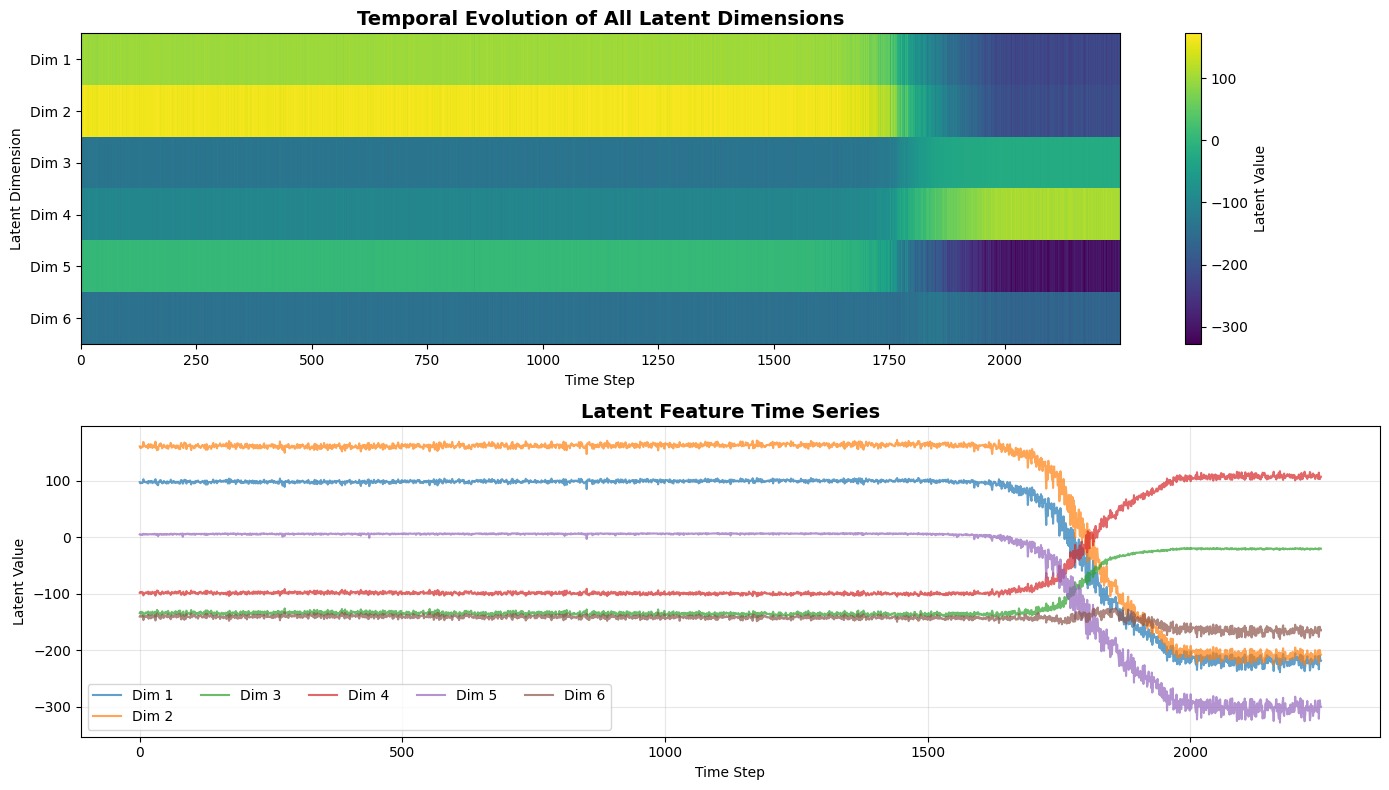


Temporal Analysis:
------------------------------------------------------------
Dim 1: Trend=-0.1305/step, Coefficient of Variation=3.137
Dim 2: Trend=-0.1505/step, Coefficient of Variation=1.487
Dim 3: Trend=+0.0477/step, Coefficient of Variation=0.389
Dim 4: Trend=+0.0833/step, Coefficient of Variation=1.256
Dim 5: Trend=-0.1257/step, Coefficient of Variation=2.108
Dim 6: Trend=-0.0085/step, Coefficient of Variation=0.062

Interpretation:
  - Heatmap reveals synchronized patterns across dimensions
  - Time series shows process evolution and potential anomaly points
  - Positive/negative trends indicate process drift over time


In [12]:
# --- XAI Visualization 3: Temporal Evolution of Latent Features ---

# Create heatmap showing how all latent dimensions evolve over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Heatmap of latent feature temporal evolution
im = ax1.imshow(latent_features.T, aspect='auto', cmap='viridis', interpolation='nearest')
ax1.set_title('Temporal Evolution of All Latent Dimensions', fontweight='bold', fontsize=14)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Latent Dimension')
ax1.set_yticks(range(latent_dim))
ax1.set_yticklabels([f'Dim {i+1}' for i in range(latent_dim)])
cbar = plt.colorbar(im, ax=ax1, label='Latent Value')

# Plot 2: Time series of each latent dimension
time_steps = range(len(latent_features))
for i in range(latent_dim):
    ax2.plot(time_steps, latent_features[:, i], label=f'Dim {i+1}', alpha=0.7)

ax2.set_title('Latent Feature Time Series', fontweight='bold', fontsize=14)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Latent Value')
ax2.legend(loc='best', ncol=min(latent_dim, 5))
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Compute and display temporal statistics
print("\nTemporal Analysis:")
print("-" * 60)
for i in range(latent_dim):
    trend = np.polyfit(time_steps, latent_features[:, i], deg=1)[0]
    stability = np.std(latent_features[:, i]) / (np.abs(np.mean(latent_features[:, i])) + 1e-8)
    print(f"Dim {i+1}: Trend={trend:+.4f}/step, Coefficient of Variation={stability:.3f}")
print("\nInterpretation:")
print("  - Heatmap reveals synchronized patterns across dimensions")
print("  - Time series shows process evolution and potential anomaly points")
print("  - Positive/negative trends indicate process drift over time")

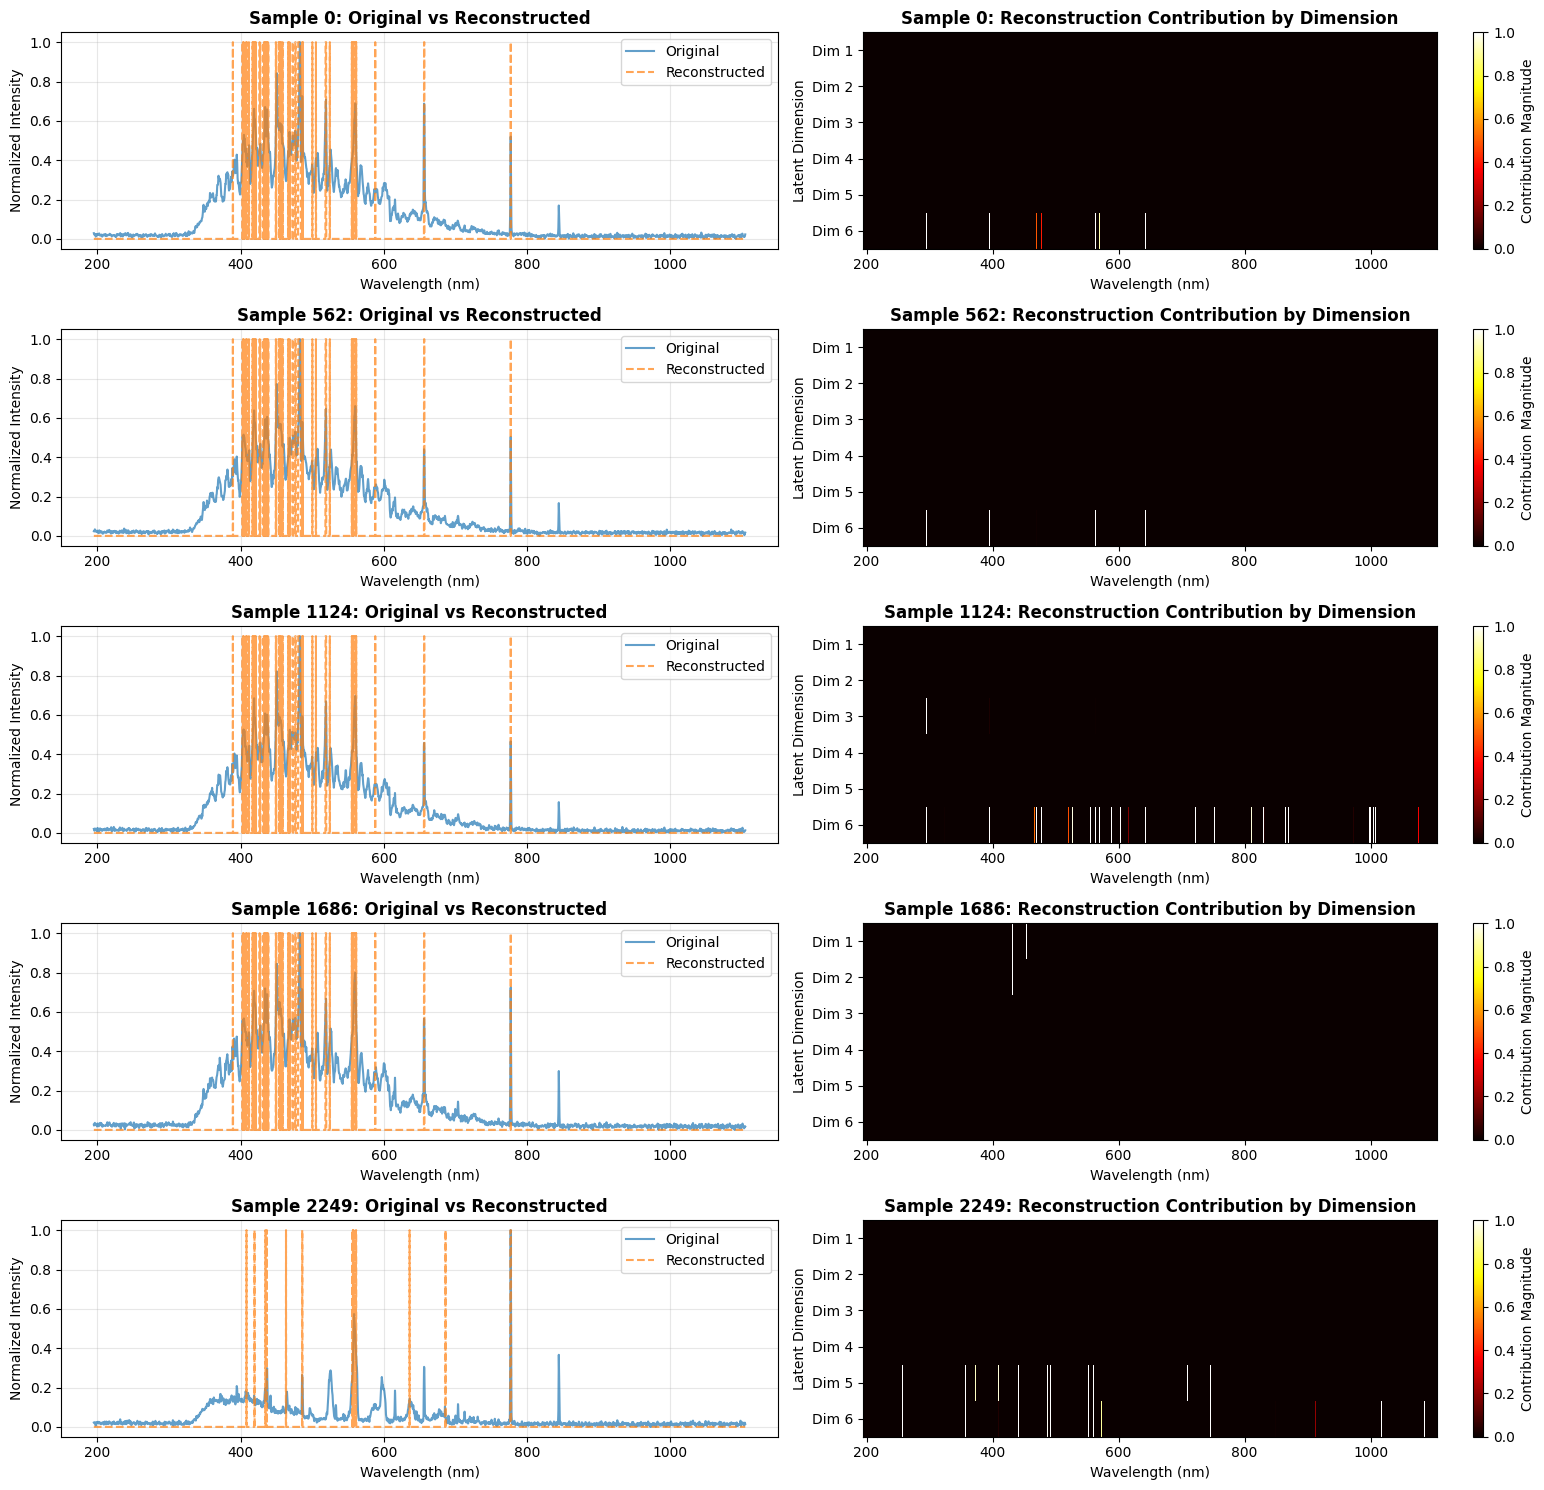


Reconstruction Contribution Summary:
------------------------------------------------------------
Dim 1: Mean contribution = 0.0000 (0.0% of total)
Dim 2: Mean contribution = 0.0011 (3.6% of total)
Dim 3: Mean contribution = 0.0000 (0.0% of total)
Dim 4: Mean contribution = 0.0000 (0.0% of total)
Dim 5: Mean contribution = 0.0134 (44.0% of total)
Dim 6: Mean contribution = 0.0160 (52.4% of total)

Interpretation:
  - Brighter regions show which wavelengths each dimension controls
  - High contribution indicates the dimension is critical for that spectral region
  - This reveals the physical features (peaks/valleys) each dimension represents


In [13]:
# --- XAI Visualization 4: Reconstruction Contribution Analysis ---

# Select sample time points for analysis
n_samples = 5
sample_indices = np.linspace(0, len(transposed_data_np)-1, n_samples, dtype=int)

# Convert wavelengths to numpy array for consistent indexing
wavelengths_np = wavelengths.to_numpy()

# Analyze how each dimension contributes to reconstruction
fig, axes = plt.subplots(n_samples, 2, figsize=(16, 3*n_samples))

for idx, sample_idx in enumerate(sample_indices):
    # Original and full reconstruction
    original = transposed_data_np[sample_idx]
    reconstructed = vae.predict(transposed_data_np[sample_idx:sample_idx+1], verbose=0)[0]
    
    # Plot original vs reconstructed using actual wavelengths
    ax1 = axes[idx, 0] if n_samples > 1 else axes[0]
    ax1.plot(wavelengths_np, original, label='Original', alpha=0.7, linewidth=1.5)
    ax1.plot(wavelengths_np, reconstructed, label='Reconstructed', alpha=0.7, linewidth=1.5, linestyle='--')
    ax1.set_title(f'Sample {sample_idx}: Original vs Reconstructed', fontweight='bold')
    ax1.set_xlabel('Wavelength (nm)')
    ax1.set_ylabel('Normalized Intensity')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Compute per-dimension contribution by ablation
    # encoder.predict returns [z_mean, z_log_var], we use z_mean (index 0)
    encoder_output = vae.encoder.predict(transposed_data_np[sample_idx:sample_idx+1], verbose=0)
    latent_code = encoder_output[0]  # Get z_mean as numpy array
    
    contributions = np.zeros((latent_dim, len(original)))
    
    for dim in range(latent_dim):
        # Zero out one dimension at a time
        ablated_latent = latent_code.copy()
        ablated_latent[0, dim] = 0
        ablated_recon = vae.decoder.predict(ablated_latent, verbose=0)[0]
        # Contribution = difference when dimension is removed
        contributions[dim] = np.abs(reconstructed - ablated_recon)
    
    # Plot contribution heatmap with proper wavelength extent
    ax2 = axes[idx, 1] if n_samples > 1 else axes[1]
    im = ax2.imshow(contributions, aspect='auto', cmap='hot', interpolation='nearest',
                    extent=[float(wavelengths_np.min()), float(wavelengths_np.max()), latent_dim-0.5, -0.5])
    ax2.set_title(f'Sample {sample_idx}: Reconstruction Contribution by Dimension', fontweight='bold')
    ax2.set_xlabel('Wavelength (nm)')
    ax2.set_ylabel('Latent Dimension')
    ax2.set_yticks(range(latent_dim))
    ax2.set_yticklabels([f'Dim {i+1}' for i in range(latent_dim)])
    plt.colorbar(im, ax=ax2, label='Contribution Magnitude')

plt.tight_layout()
plt.show()

# Summary statistics
print("\nReconstruction Contribution Summary:")
print("-" * 60)
mean_contributions = np.mean(contributions, axis=1)
for i, contrib in enumerate(mean_contributions):
    pct = 100 * contrib / (mean_contributions.sum() + 1e-8)
    print(f"Dim {i+1}: Mean contribution = {contrib:.4f} ({pct:.1f}% of total)")

print("\nInterpretation:")
print("  - Brighter regions show which wavelengths each dimension controls")
print("  - High contribution indicates the dimension is critical for that spectral region")
print("  - This reveals the physical features (peaks/valleys) each dimension represents")

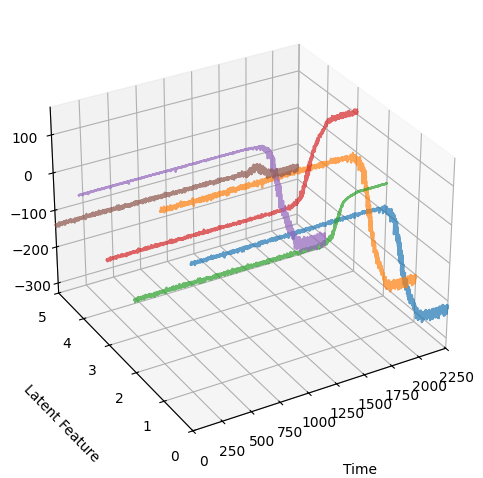

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Use the latent_features variable defined in the previous cell
latent_features_full = latent_features

# Handle NaN/Inf values before plotting
latent_features_full = np.nan_to_num(latent_features_full, nan=0.0, posinf=0.0, neginf=0.0)

# Create a larger figure and 3D axis with adjusted margins
fig = plt.figure(figsize=(6, 9))
ax = fig.add_subplot(111, projection='3d')

# Prepare the data for plotting
time = np.arange(latent_features_full.shape[0])
features = np.arange(latent_features_full.shape[1])

# Plot with better separation and slightly transparent lines
for feature in features:
    ax.plot(time, np.full_like(time, feature), latent_features_full[:, feature], alpha=0.7)

# Set labels
ax.set_xlabel('Time', labelpad=20)  # Adding padding to the labels
ax.set_ylabel('Latent Feature', labelpad=20)
ax.set_zlabel('Value', labelpad=20)

# Adjusting the view angle and margins
ax.view_init(elev=30, azim=240)  # Adjust the viewing angle to make axes labels more visible
fig.subplots_adjust(left=0.1, right=0.85, top=0.85, bottom=0.1)  # Adjust the margins

# Set axis limits to better visualize the data
ax.set_xlim([0, latent_features_full.shape[0]])
ax.set_ylim([0, latent_features_full.shape[1] - 1])

# Safely calculate z-axis limits
z_min = np.nanmin(latent_features_full)
z_max = np.nanmax(latent_features_full)
if np.isfinite(z_min) and np.isfinite(z_max) and z_min != z_max:
    ax.set_zlim([z_min, z_max])
else:
    ax.set_zlim([-1, 1])  # Default range if data is invalid

# Display the plot
plt.show()

Shape of latent_features: (2250, 6)
Expanded shape of latent_features: (2250, 1, 6)
Shape of X_train: (2249, 1, 6)
Shape of y_train: (2249, 6)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 6)      │      6,918 │ input_layer_4[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1, 6)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1, 6)      │         12 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 6)      │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1, 64)     │        448 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 64)     │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1, 6)      │        390 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 6)      │         12 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 6)      │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 6)      │      6,918 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1, 6)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 6)      │         12 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1, 6)      │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1, 64)     │        448 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1, 64)     │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1, 6)      │        390 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 6)      │         12 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1, 6)      │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,078 (62.80 KB)

 Trainable params: 16,078 (62.80 KB)

 Non-trainable params: 0 (0.00 B)

Training Transformer model...
Epoch 1/50
Epoch 1/50


/Users/linli-shang/miniforge3/envs/scientific_env/lib/python3.10/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 12817.9951 - val_loss: 45914.3867
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 12817.9951 - val_loss: 45914.3867
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 10223.5898 - val_loss: 77801.0938
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 10223.5898 - val_loss: 77801.0938
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 7194.3179 - val_loss: 144858.0781
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 7194.3179 - val_loss: 144858.0781
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 4386.6714 - val_loss: 236122.0938
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 4386.6714 - val_loss: 236122.0938
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 2608.8430 - val_loss: 313065.6250
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 2608.8430 - val_loss: 313065.6250
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1887.0376 - val_loss: 

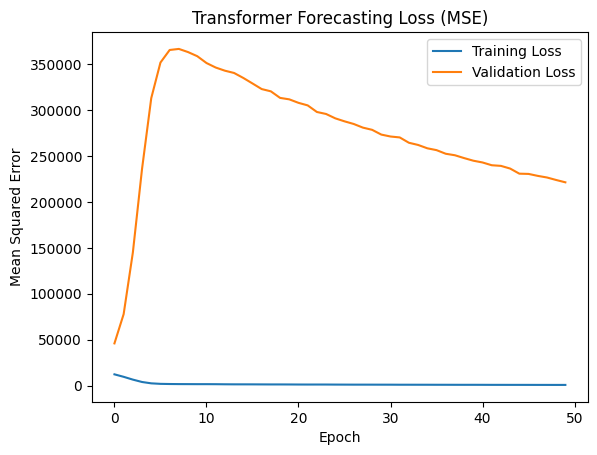

In [15]:
# --- Transformer Model Definition and Training (Next-Step Prediction) ---

# Assuming latent_features is your input data
print("Shape of latent_features:", latent_features.shape)

# Handle potential NaNs in latent features
latent_features = np.nan_to_num(latent_features)

# Ensure latent_features is a 3D array (samples, time steps, features)
if len(latent_features.shape) == 2:
    latent_features = np.expand_dims(latent_features, axis=1)
    print("Expanded shape of latent_features:", latent_features.shape)

# Prepare Data for Forecasting (Next-Step Prediction)
# Input (X): State at time t
# Target (y): State at time t+1
X_train = latent_features[:-1]  
y_train = latent_features[1:]   

# Reshape y_train to (samples, features) for the Dense output layer
y_train = y_train.reshape(y_train.shape[0], y_train.shape[2])

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

# --- Build Transformer Model ---
from tensorflow.keras import layers, models

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(latent_dim, activation="linear")(x)
    return models.Model(inputs, outputs)

input_shape = (X_train.shape[1], X_train.shape[2])

transformer_model = build_transformer_model(
    input_shape,
    head_size=64,
    num_heads=4,
    ff_dim=64,
    num_transformer_blocks=2,
    mlp_units=[64],
    mlp_dropout=0.1,
    dropout=0.1,
)

transformer_model.summary()

# Use MSE loss for regression
transformer_model.compile(optimizer='adam', loss='mse')

# Train the Transformer model
print("Training Transformer model...")
history = transformer_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Transformer Forecasting Loss (MSE)')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Alias for compatibility with downstream cells
lstm_model = transformer_model


## Step 5: Temporal Forecasting with LSTM
We train an LSTM to predict the *next* latent state based on the current state. This allows us to capture the temporal dynamics of the process.
*   **Input:** Latent vector at time $t$.
*   **Target:** Latent vector at time $t+1$.
*   **Loss:** Mean Squared Error (MSE).

In [16]:
# --- Evaluate VAE Reconstruction Error and LSTM Prediction Error ---

# 1. VAE Reconstruction Error (Spatial Anomaly)
# How well can the VAE reconstruct the current spectrum?
reconstructed_data = vae(transposed_data_np)
reconstruction_errors = tf.reduce_mean(tf.square(transposed_data_np - reconstructed_data), axis=1).numpy()

# 2. LSTM Prediction Error (Temporal Anomaly)
# How well did the LSTM predict the current state based on the previous state?

# Predict next steps for the whole sequence (except the last one which has no next step)
X_pred_input = latent_features[:-1]
predicted_next_latent = lstm_model.predict(X_pred_input)

# Alias for compatibility with downstream cells that expect `lstm_predictions`
lstm_predictions = predicted_next_latent

# Actual next steps
actual_next_latent = latent_features[1:].reshape(predicted_next_latent.shape)

# Calculate MSE between predicted and actual next latent state
lstm_prediction_mse = np.mean(np.square(actual_next_latent - predicted_next_latent), axis=1)

# Pad the first value (since we can't predict t=0) to match the original data length
# We repeat the first error or pad with 0
lstm_anomaly_score = np.pad(lstm_prediction_mse, (1, 0), mode='edge')

# 3. Combine Signals
# Normalize both scores to have comparable magnitude before adding?
# For now, we just add them. You might want to use MinMaxScaler on both if scales are very different.
combined_signal = reconstruction_errors + lstm_anomaly_score

print("Shape of reconstruction_errors:", reconstruction_errors.shape)
print("Shape of lstm_anomaly_score:", lstm_anomaly_score.shape)
print("Shape of combined_signal:", combined_signal.shape)

/Users/linli-shang/miniforge3/envs/scientific_env/lib/python3.10/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Shape of reconstruction_errors: (2250,)
Shape of lstm_anomaly_score: (2250,)
Shape of combined_signal: (2250,)
Shape of reconstruction_errors: (2250,)
Shape of lstm_anomaly_score: (2250,)
Shape of combined_signal: (2250,)


## Step 6: Anomaly Detection & Evaluation
We combine two metrics to detect anomalies:
1.  **Reconstruction Error (VAE):** Measures how "unusual" the current spectrum is spatially (e.g., new peaks appearing).
2.  **Prediction Error (LSTM):** Measures how "unexpected" the temporal transition was (e.g., sudden jump in intensity).

The **Combined Anomaly Score** gives a holistic view of process deviations.

In [17]:
reconstructed_data

<tf.Tensor: shape=(2250, 4550), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [18]:
latent_features

array([[[  97.13764  ,  160.5811   , -134.3636   ,  -98.512856 ,
            4.7744956, -140.69429  ]],

       [[  95.23589  ,  158.13824  , -132.58562  ,  -97.07873  ,
            4.1270823, -138.9961   ]],

       [[  96.079414 ,  159.41383  , -133.60146  ,  -97.848816 ,
            4.2759156, -140.03119  ]],

       ...,

       [[-210.2535   , -199.87993  ,  -19.793842 ,  102.70551  ,
         -288.81622  , -158.6335   ]],

       [[-218.15817  , -207.29378  ,  -20.640936 ,  106.47175  ,
         -299.81897  , -164.80315  ]],

       [[-218.7349   , -208.02673  ,  -20.524277 ,  106.9094   ,
         -300.37283  , -164.89937  ]]], dtype=float32)

In [19]:
lstm_predictions

array([[  90.04646  ,  151.71024  , -130.37637  ,  -93.84207  ,
          -0.678375 , -138.66197  ],
       [  90.07832  ,  151.764    , -130.4225   ,  -93.875015 ,
          -0.6799457, -138.71135  ],
       [  90.317856 ,  152.16833  , -130.76927  ,  -94.12262  ,
          -0.6917584, -139.08244  ],
       ...,
       [ 342.9082   ,  578.5308   , -496.4413   , -355.22714  ,
         -13.147306 , -530.41583  ],
       [ 333.3335   ,  562.3691   , -482.5801   , -345.3297   ,
         -12.675161 , -515.582    ],
       [ 346.08185  ,  583.8878   , -501.0357   , -358.50775  ,
         -13.303801 , -535.3327   ]], dtype=float32)

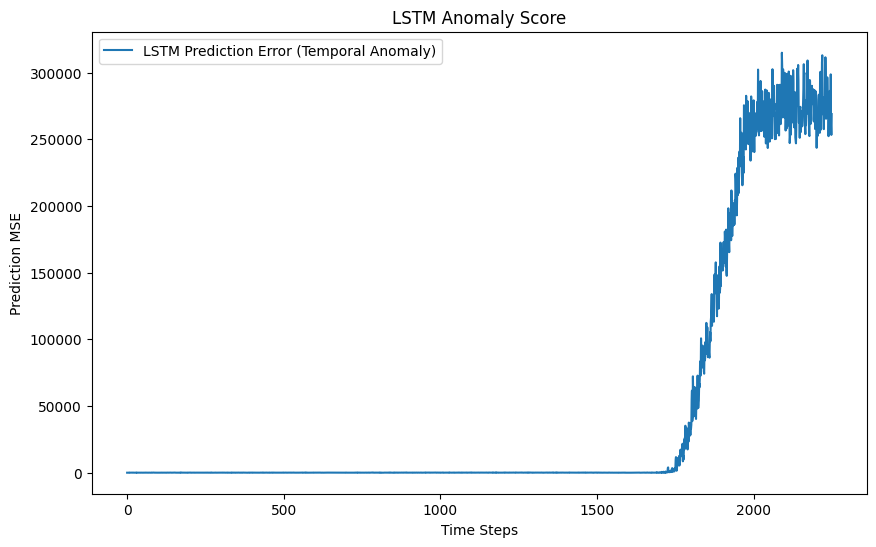

In [20]:
import matplotlib.pyplot as plt

# Plot the LSTM Anomaly Score (Prediction Error)
plt.figure(figsize=(10, 6))
plt.plot(lstm_anomaly_score, label='LSTM Prediction Error (Temporal Anomaly)')
plt.title('LSTM Anomaly Score')
plt.xlabel('Time Steps')
plt.ylabel('Prediction MSE')
plt.legend()
plt.show()

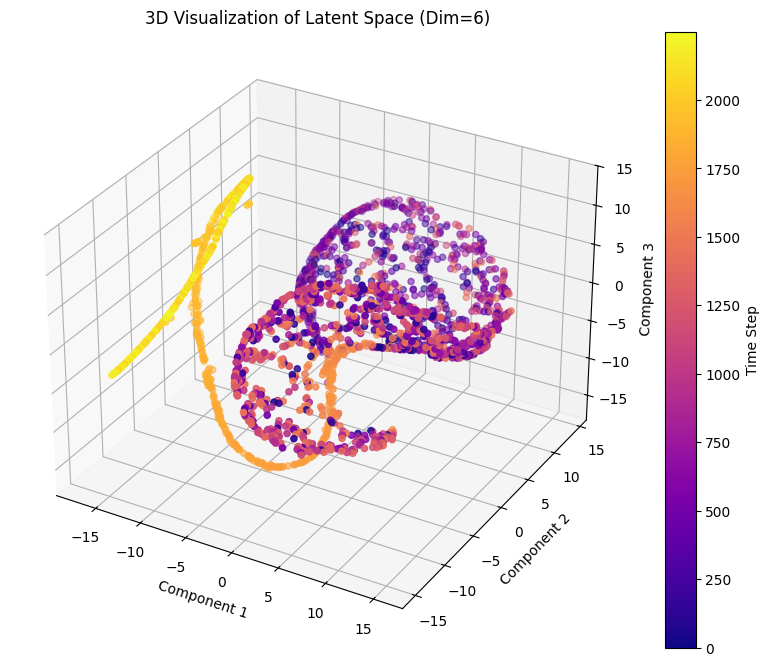

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming latent_features is a 3D array
# Reshape the 3D array to 2D (combining last two dimensions)
latent_features_reshaped = latent_features.reshape(latent_features.shape[0], -1)

# Handle NaNs (Crucial for this dataset)
latent_features_reshaped = np.nan_to_num(latent_features_reshaped)

# Check dimensionality before running t-SNE
n_features = latent_features_reshaped.shape[1]

if n_features > 3:
    # Perform t-SNE to reduce latent features to 3D
    tsne = TSNE(n_components=3, random_state=42)
    latent_features_3d = tsne.fit_transform(latent_features_reshaped)
elif n_features == 3:
    # Already 3D, use directly
    latent_features_3d = latent_features_reshaped
else:
    # Less than 3D (e.g., 2D), pad with zeros to visualize in 3D
    print(f"Latent dimension is {n_features}, skipping t-SNE and padding with zeros for 3D plot.")
    padding = np.zeros((latent_features_reshaped.shape[0], 3 - n_features))
    latent_features_3d = np.hstack((latent_features_reshaped, padding))

# Plot the latent features in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(latent_features_3d[:, 0], latent_features_3d[:, 1], latent_features_3d[:, 2], 
                c=np.arange(len(latent_features_3d)), cmap='plasma')

# Add labels and title
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title(f'3D Visualization of Latent Space (Dim={n_features})')

# Add color bar
plt.colorbar(sc, label='Time Step')

# Show the plot
plt.show()

## Step 7: Physics Interpretation & Notes
- The **optimal latent dimension** is selected by the Elbow Method, ensuring each learned factor corresponds to a physically meaningful spectral pattern rather than redundant noise.
- The **latent traversal plots** reveal how each dimension modulates specific wavelength regions, helping engineers link latent factors to plasma species or chamber conditions.
- The **LSTM prediction error** flags temporal deviations, so sudden process drifts or endpoint events become visible as spikes in the combined anomaly score.

> **Next Steps:** Re-run the full notebook whenever new spectral data becomes available to refresh the latent explanation and anomaly thresholds.